# DandeLiion API - Example Notebook

In [1]:
import dandeliion.client as dandeliion
import numpy as np
import matplotlib.pyplot as plt
from pybamm import Experiment

# The following lines enable logging output in this notebook
import sys
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
dandeliion.__version__

'1.0.0rc2'

### Authentication
Define the simulator object by providing the API URL and API token:

In [3]:
api_url = "https://api.dandeliion.com/v1"
api_key = "f1543b9ff2001d04bd2c002d9375c8a28ad0bcac9914ce5d8f0e0b98ef4404cf"
simulator = dandeliion.Simulator(api_url, api_key)

### Battery parameters
Can be a valid BPX file name/path or already read-in valid BPX as a `dict` or `BPX` object itself:

In [4]:
params = 'AE_gen1_BPX.json'

### Experiment
PyBaMM `Experiment` object, for example:

In [5]:
experiment = Experiment(
  [
    (
      "Discharge at 1C until 3.8 V",
      "Hold at 3.8 V for 10 minutes (5 second period)",
      "Rest for 300 seconds",
      "Charge at 2000 mA for 1 hour or until 4.0 V",
      "Rest for 5 min",
      "Discharge at 20W for 25 minutes or until 2.5V",
      "Rest for 300 s (1 second period)",
      "Charge at C/2 until 4.0 V (0.5 min period)",
      "Hold at 4.0V for 0.1 hr (1s period)"
    )
  ]
  * 2,
  period = "10 s",
)

### Additional model/backend-specific parameters
Define a dictionary of extra parameters outside the BPX standard, such as mesh, initial state of charge or voltage, etc.:

In [6]:
extra_params = {}

# Number of mesh points in PyBaMM format (default is 16 mesh points everywhere):
extra_params['Mesh'] = {"x_n": 16, "x_s": 8, "x_p": 16, "r_n": 16, "r_p": 16}

# Initial state of charge (default is 1):
extra_params['Initial SOC'] = 1.0

### Start the simulation in the cloud

In [7]:
solution = dandeliion.solve(
    simulator=simulator,
    params=params,
    experiment=experiment,      # optional (1C discharge for 1 hour or until the `Lower voltage cut-off [V]` from BPX will be used by default)
    extra_params=extra_params,  # optional (initial conditions from the BPX, fully charged state, and single cell Newman model with constant temperature will be used by default)
    is_blocking=True            # optional (`True` by default)
)

print("Solution status:", solution.status)

/Users/maximedeckers/opt/anaconda3/envs/dev-env/lib/python3.9/site-packages/pydantic/_internal/_decorators_v1.py:171: UserWarning: The minimum voltage computed from the STO limits (2.4988861558265327 V) is less than the lower voltage cut-off (2.5 V) with the absolute tolerance v_tol = 0.001 V
  model_dict_new = validator(model_dict)


INFO:dandeliion.client.simulator:[running] | 
INFO:dandeliion.client.simulator:[success] | [2025-04-30 14:04:00.357] [info] Total time: 3.733 s
Solution status: success


In [8]:
solution.status

'success'

### Accessing the log file 

In [9]:
print(solution.log)

[2025-04-30 14:03:56.623] [info] Starting dandeliion-models v0.1.1...
[2025-04-30 14:03:56.623] [info] Parsing input JSON file parameters.json...
[2025-04-30 14:03:56.623] [info] Input JSON file parsing time: 0.105 ms
[2025-04-30 14:03:56.623] [info] Initialising simulation parameters...
[2025-04-30 14:03:56.623] [info] Title: About:Energy Gen1 Demo 21700 NMC811|graphite 5 Ah cell
[2025-04-30 14:03:56.623] [info] Model: DFN
[2025-04-30 14:03:56.629] [info] Thermal model: Isothermal
[2025-04-30 14:03:56.629] [info] Found DandeLiion Experiment...
[2025-04-30 14:03:56.629] [info] Number of instructions to parse: 18
[2025-04-30 14:03:56.629] [info] Solver mode: Fast (default)
[2025-04-30 14:03:56.630] [info] Simulation parameters initialisation time: 6.116 ms
[2025-04-30 14:03:56.630] [info] Starting the simulation...
[2025-04-30 14:03:56.630] [info] Computational mesh: 15x15 + 7 + 15x15 finite volumes
[2025-04-30 14:03:56.630] [info] Total number of equations: 588
[2025-04-30 14:03:56.630

### Results
Print all available keys in the solution object.
Here method `keys()` is used to get all available keys in the solution object.

In [10]:
for key in sorted(solution.keys()):
    print(key)

Current [A]
Electrolyte concentration [mol.m-3]
Electrolyte potential [V]
Electrolyte x-coordinate [m]
Temperature [K]
Time [s]
Voltage [V]
X-averaged negative electrode exchange current density [A.m-2]
X-averaged negative electrode potential [V]
X-averaged negative electrode surface concentration [mol.m-3]
X-averaged positive electrode exchange current density [A.m-2]
X-averaged positive electrode potential [V]
X-averaged positive electrode surface concentration [mol.m-3]


In [11]:
# Print the final values of time, voltage, and temperature
print(f"Final time [s]: {solution['Time [s]'][-1]}")
print(f"Final voltage [V]: {solution['Voltage [V]'][-1]}")
print(f"Final temperature [K]: {solution['Temperature [K]'][-1]}")

INFO:dandeliion.client.solution:Fetching 'Time [s]' column from simulator
Final time [s]: 15189.777343750002
INFO:dandeliion.client.solution:Fetching 'Voltage [V]' column from simulator
Final voltage [V]: 4.0
INFO:dandeliion.client.solution:Fetching 'Temperature [K]' column from simulator
Final temperature [K]: 298.15


INFO:dandeliion.client.solution:Fetching 'Current [A]' column from simulator


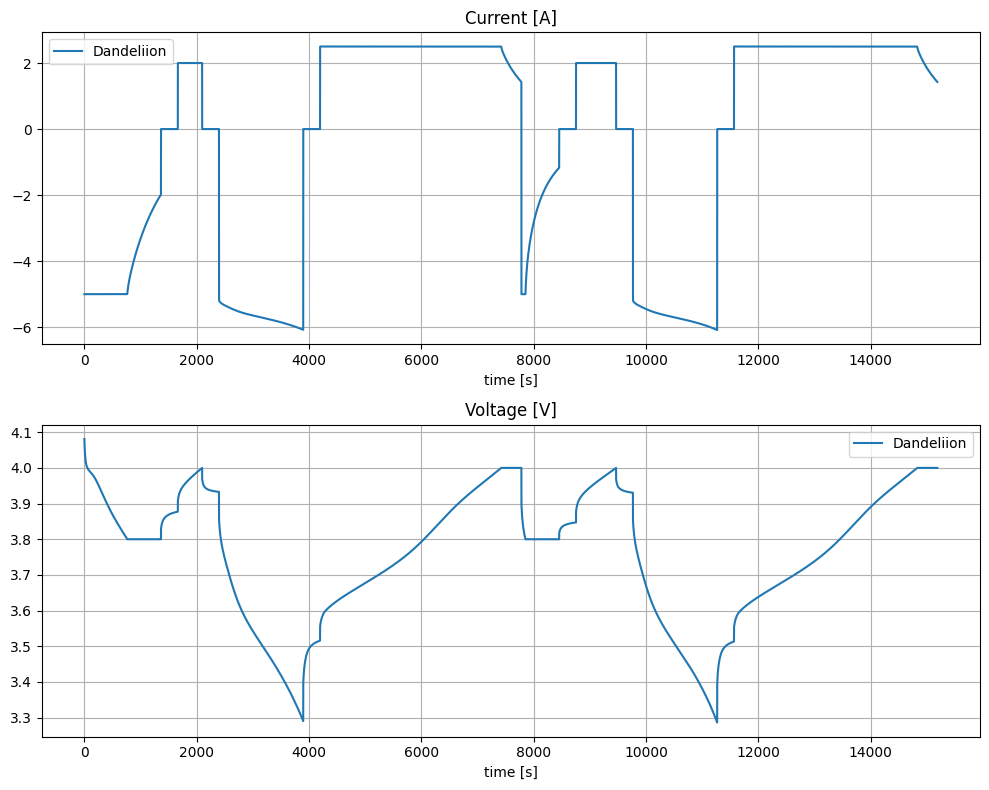

In [12]:
# Plot current and voltage vs time.
# Here we access scalar values vs time.
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(solution["Time [s]"], solution["Current [A]"], label="Dandeliion")
axs[0].set_xlabel("time [s]")
axs[0].set_title("Current [A]")
axs[0].legend()
axs[0].grid()
axs[1].plot(solution["Time [s]"], solution["Voltage [V]"], label="Dandeliion")
axs[1].set_xlabel("time [s]")
axs[1].set_title("Voltage [V]")
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()

INFO:dandeliion.client.solution:Fetching 'Electrolyte x-coordinate [m]' column from simulator
INFO:dandeliion.client.solution:Fetching 'Electrolyte concentration [mol.m-3]' column from simulator


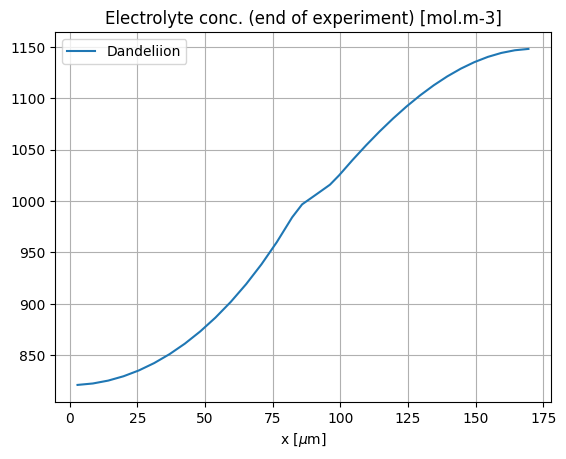

In [13]:
# Concentration in the electrolyte vs `x` at the last time step.
# Here we access spatially dependent values vs time.
plt.plot(
    solution["Electrolyte x-coordinate [m]"] * 1e6,
    solution["Electrolyte concentration [mol.m-3]"][-1],
    label="Dandeliion",
)
plt.xlabel(r"x [$\mu$m]")
plt.title("Electrolyte conc. (end of experiment) [mol.m-3]")
plt.legend()
plt.grid()
plt.show()

In [14]:
# A list of output times (optional)
t_eval = np.arange(0, 20, 1)

# If the user needs the solution at the `t_eval` times, the following code can be used (works only correctly on columns with timeline data).
# This is a linear interpolation with constant extrapolation:
print("Time [s]\tVoltage [V]")
for t, voltage in zip(t_eval, solution["Voltage [V]"](t=t_eval)):
    print(f"{t}\t{voltage}")


Time [s]	Voltage [V]
0	4.081016267199651
1	4.0756523433837
2	4.0707278008778855
3	4.066037768830061
4	4.062075832090936
5	4.058194794830556
6	4.054313757570177
7	4.051229625220152
8	4.048487023545993
9	4.045744421871834
10	4.0430018201976745
11	4.0402592185235155
12	4.037516616849357
13	4.0351049924377955
14	4.033465648305629
15	4.031826304173462
16	4.030186960041296
17	4.02854761590913
18	4.026908271776962
19	4.025268927644796
